In [281]:
#!/usr/bin/env python
import networkx as nx
import numpy as np
import math
import csv
import random as rand
import sys
import community
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

## hide warning messages 
import warnings
warnings.filterwarnings('ignore')

#### Implementation of GirvanNewman community detection algorism 

#### - Define all the functions 

In [244]:
_DEBUG_ = False
def CmtyGirvanNewmanStep(G):
    if _DEBUG_:
        print("Calling CmtyGirvanNewmanStep")
    init_ncomp = nx.number_connected_components(G)    #no of components, in most cases, everything is connected, so it is one
    ncomp = init_ncomp
    while ncomp <= init_ncomp:
        bw = nx.edge_betweenness_centrality(G, weight='weight')    #edge betweenness for G
        #find the edge with max centrality
        max_ = max(bw.values())
        #find the edge with the highest centrality and remove all of them if there is more than one!
        for k, v in bw.items():
            if float(v) == max_:
                G.remove_edge(k[0],k[1])    #remove the central edge
        ncomp = nx.number_connected_components(G)    #recalculate the no of components

In [245]:
def is_partition(G, partition):
    ## return true if it is a partiction 
    return all(sum(1 if v in c else 0 for c in partition) == 1 for v in G)
def modularity(G, communities, weight='weight'):
    r"""Returns the modularity of the given partition of the graph.
    Examples
    --------
    >>> G = nx.barbell_graph(3, 0)
    >>> nx.modularity(G, [{0, 1, 2}, {3, 4, 5}])
    0.35714285714285704
    """
#    if not is_partition(G, communities):
#        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))  ## 
    return Q* norm

In [286]:
def runGirvanNewman(G):
    G = G.copy()
    G_init = G.copy()
    Q_list = []
    while True:
        CmtyGirvanNewmanStep(G)
        comps = nx.connected_components(G)
        communities = list(comps)
        Q = modularity(G_init,communities)
        c_n = nx.number_connected_components(G)
        Q_list.append((Q,c_n,communities))
        #print('No of communities in decomposed G: %d' % c_n)
        if G.number_of_edges() == 0:
              break
    q,c_n,best_part = sorted(Q_list,key=lambda x:x[0],reverse=True)[0]
    part = {}
    for index,c in enumerate(best_part):
        for node in c:
            part[node] = index

    return (part,q,c_n)

#### Draw charts and compare modularity with nx community detection algorism 

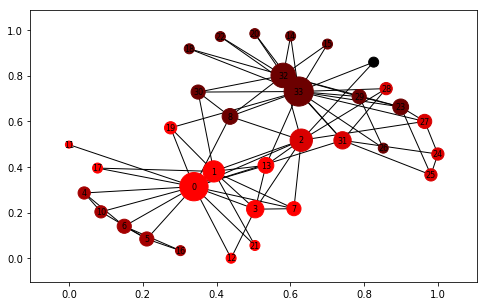

In [295]:
G = nx.karate_club_graph()
part,q,n = runGirvanNewman(G)
k = nx.degree(G)
layout = nx.spring_layout(G)
plt.figure(1, figsize=(8,5))
nx.draw_networkx(G,
                 pos=layout,
                 nodelist=k.keys(),
                 node_size = [d*50 for d in list(k.values())],  ## change the size of the node, based on degree
                 node_color=list(part.values()),                   ## change color abased on degree
                 font_size=8,
                 cmap='flag',                                 ## choose one color map http://matplotlib.org/users/colormaps.html
                 )


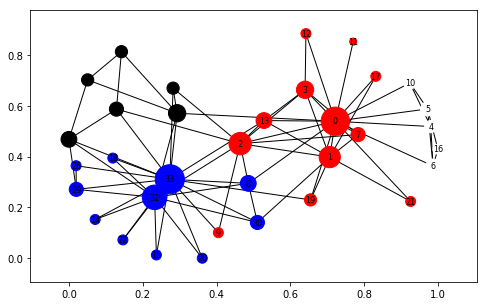

In [291]:
G = nx.karate_club_graph()
part2 = community.best_partition(G)
k = nx.degree(G)
layout = nx.spring_layout(G)
plt.figure(1, figsize=(8,5))
nx.draw_networkx(G,
                 pos=layout,
                 nodelist=k.keys(),
                 node_size = [d*50 for d in list(k.values())],  ## change the size of the node, based on degree
                 node_color=list(part2.values()),                   ## change color abased on degree
                 font_size=8,
                 cmap='flag',                                 ## choose one color map http://matplotlib.org/users/colormaps.html
                 )

In [303]:
#####################
# cross comparision 
#####################

## transfrom 
com = {}
for key, value in sorted(part2.items()):
    com.setdefault(value, []).append(key)
q2 = modularity(G,com.values())

print('GirvanNewman modularity: ', q)
print('netwrokx community modularity: ', q2)

GirvanNewman modularity:  0.4012984878369487
netwrokx community modularity:  0.41880341880341804
